In [4]:
# %% [markdown]
# ## Unsupervised AAE – MNIST
# Stand-alone version (no inheritance) + clustering accuracy

# %%
import torch, torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt

from unsupervised import (
    UAAEConfig,
    UnsupervisedAdversarialAutoencoder,
)
from dataloader import load_mnist_data          # your helper


In [5]:
# %%
BATCH_SIZE   = 128
VAL_FRAC     = 0.10
device       = torch.device("mps")

# full train/test loaders
train_full, test_loader = load_mnist_data(batch_size=BATCH_SIZE, num_samples=-1)

# carve a validation split out of the training loader’s dataset
full_train_ds = train_full.dataset            # underlying Dataset object
n_val         = int(len(full_train_ds) * VAL_FRAC)

val_ds, train_ds = torch.utils.data.random_split(
    full_train_ds, [n_val, len(full_train_ds) - n_val], generator=torch.Generator().manual_seed(42)
)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}  |  Val samples: {len(val_ds)}")


Train batches: 421  |  Val samples: 6000


In [6]:
# %%
cfg = UAAEConfig(
    input_dim   = 784,
    ae_hidden   = 3000,
    disc_hidden = 3000,
    latent_dim_categorical = 30,
    latent_dim_style = 5,
    device      = device,
)

model = UnsupervisedAdversarialAutoencoder(cfg)
# model.load_weights('here')
print(model)


<UnsupervisedAAE input_dim=784, ae_hidden=3000, disc_hidden=3000, latent_dim_categorical=30, latent_dim_style=5, use_decoder_sigmoid=True, recon_loss_fn=MSELoss(), adv_loss_fn=BCEWithLogitsLoss(), device=mps>


In [ ]:
# %%
model.fit(
    train_loader  = train_loader,
    val_loader  = val_loader,     # gives val accuracy each epoch
    epochs      = 200, # 1500
    prior_std   = 1.0,
    result_folder     = Path("runs/unsup_aae"),
)


Epoch [1/200]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 1/200 - Recon: 0.2301, Disc_Cat: 1.2172, Gen_Cat: 0.8259, Disc_Style: 1.3863, Gen_Style: 0.6933


Epoch [2/200]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 2/200 - Recon: 0.2274, Disc_Cat: 1.2226, Gen_Cat: 1.0531, Disc_Style: 1.3863, Gen_Style: 0.6931


Epoch [3/200]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 3/200 - Recon: 0.2244, Disc_Cat: 1.2540, Gen_Cat: 1.0103, Disc_Style: 1.3863, Gen_Style: 0.6932


Epoch [4/200]:   0%|          | 0/421 [00:00<?, ?it/s]

Epoch 4/200 - Recon: 0.2204, Disc_Cat: 1.2597, Gen_Cat: 1.0000, Disc_Style: 1.3864, Gen_Style: 0.6933


Epoch [5/200]:   0%|          | 0/421 [00:00<?, ?it/s]

Validation Clustering Accuracy: 77.40%
Epoch 5/200 - Recon: 0.2145, Disc_Cat: 1.2699, Gen_Cat: 0.9890, Disc_Style: 1.3863, Gen_Style: 0.6932


Epoch [6/200]:   0%|          | 0/421 [00:00<?, ?it/s]

In [ ]:
# %%
test_acc = model.evaluate_clustering(test_loader)
print(f"Test clustering accuracy: {test_acc:.2%}")


Test clustering accuracy: 26.90%


ValueError: object __array__ method not producing an array

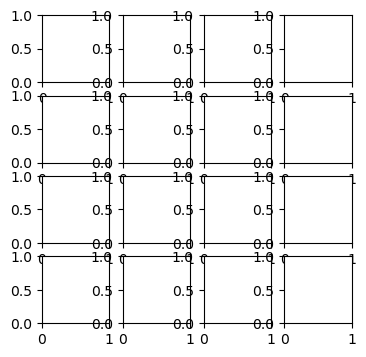

In [6]:
# %%
with torch.no_grad():
    samples = model.generate(16).cpu().view(-1, 28, 28)

fig, axes = plt.subplots(4, 4, figsize=(4,4))
for ax, img in zip(axes.flatten(), samples):
    ax.imshow(img, cmap="gray")
    ax.axis("off")
plt.tight_layout()


In [ ]:
# %%
model.save_weights("weights/unsup_aae_final")
